[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Current Stock Price: 113.72000122070312
Historical Volatility: 0.33358587153922736
Black-Scholes call price: 9.945458049771062


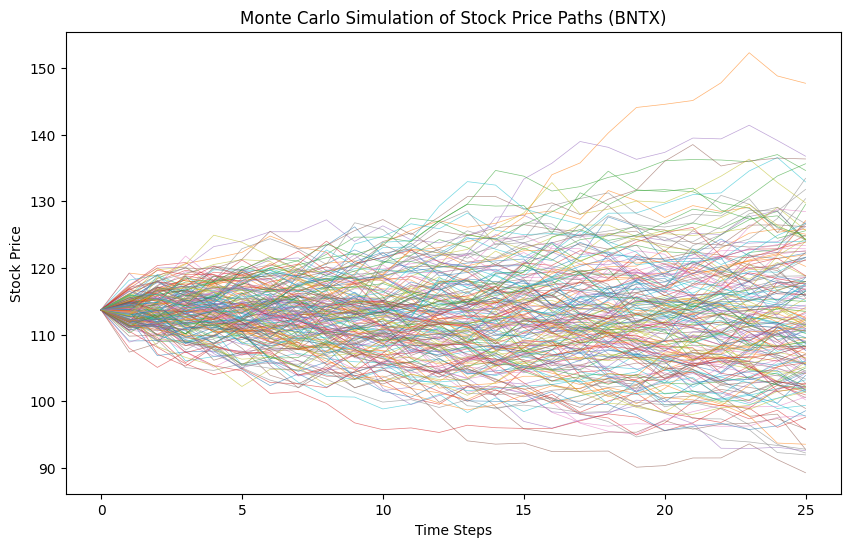

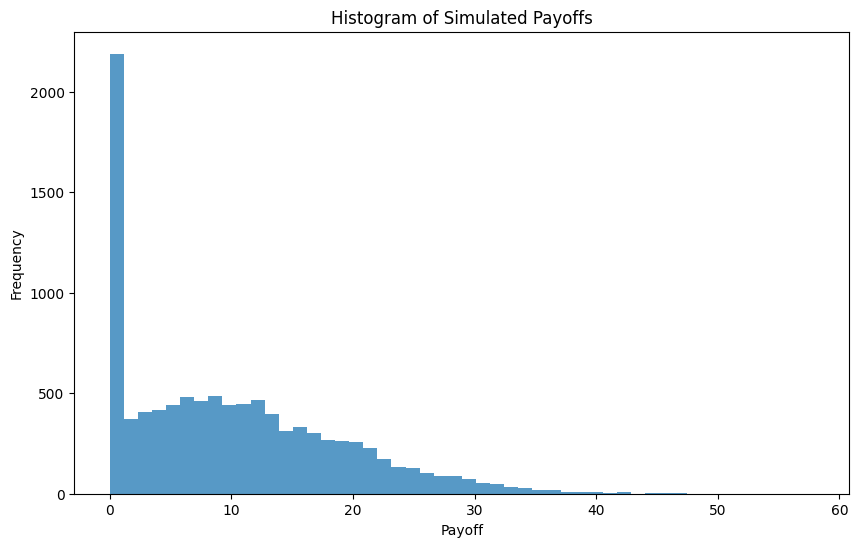

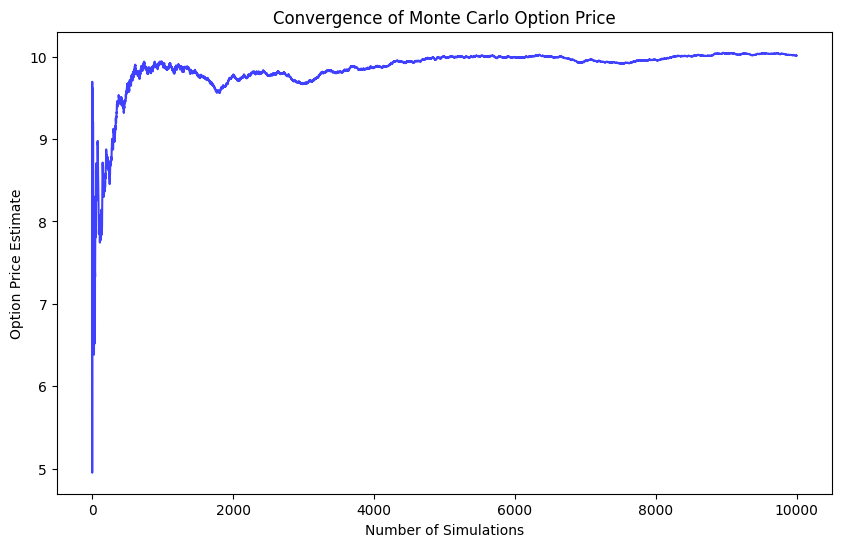

Monte Carlo call price: 10.011772626895016
Binomial Tree call price: 9.94982047734496


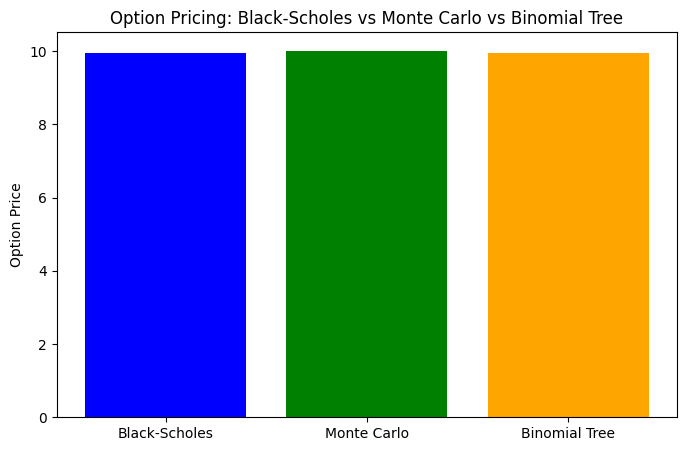

Greeks: Delta=0.8405428017278946, Gamma=0.024452841996453444, Vega=7.225332637144391, Theta=-21.87701637937416, Rho=5.865826738957422
Report saved to options_report.txt


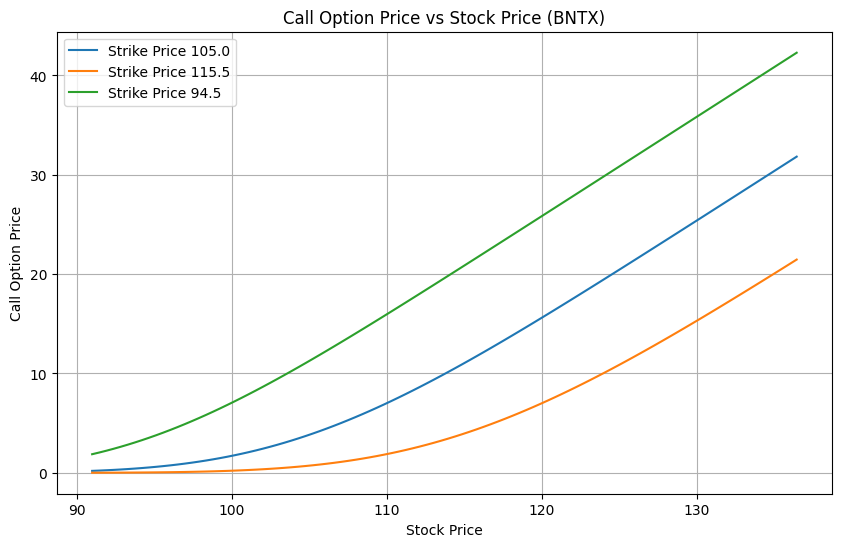

In [127]:
import numpy as np
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import os


class OptionPricing:
    def __init__(self, ticker, option_type, output_folder='output_oop'):
        """
        Initializes the option pricing class.

        Args:
            ticker (str): Stock ticker symbol.
            option_type (str): Option type ('call' or 'put'). Default is 'put'.
            output_folder (str): Directory to save output files. Default is 'output'.
        """
        self.ticker = ticker
        self.option_type = option_type
        self.output_folder = output_folder
        self.stock_data = None
        self.S = None  # Stock price
        self.sigma = None  # Volatility

    def black_scholes_option(self, S, K, T, r, sigma, q=0):
        """
        Calculate the option price using the Black-Scholes formula.

        Args:
            S (float): Current stock price.
            K (float): Strike price.
            T (float): Time to maturity in years.
            r (float): Risk-free rate.
            sigma (float): Volatility.
            q (float): Dividend rate. Default is 0.

        Returns:
            float: Option price.
        """
        d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        if self.option_type == 'call':
            price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        elif self.option_type == 'put':
            price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
        else:
            raise ValueError("option_type must be 'call' or 'put'")

        return price

    def binomial_tree_option_price(self, S, K, T, r, sigma, N):
        """
        Calculate option price using the Binomial Tree method.

        Args:
            S (float): Current stock price.
            K (float): Strike price.
            T (float): Time to maturity in years.
            r (float): Risk-free rate.
            sigma (float): Volatility.
            N (int): Number of time steps.

        Returns:
            float: Option price.
        """
        dt = T / N  # Time step
        u = np.exp(sigma * np.sqrt(dt))  # Up factor
        d = 1 / u  # Down factor
        p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

        # Initialize asset prices at maturity
        ST = np.array([S * (u ** (N - i)) * (d ** i) for i in range(N + 1)])

        # Initialize option values at maturity
        option_values = np.maximum(0, ST - K) if self.option_type == 'call' else np.maximum(0, K - ST)

        # Backward induction
        for j in range(N - 1, -1, -1):
            option_values = np.exp(-r * dt) * (p * option_values[:-1] + (1 - p) * option_values[1:])

        return option_values[0]

    def monte_carlo_option_price(self, S, K, T, r, sigma, num_simulations=10000):
        """
        Calculate option price using Monte Carlo simulation.

        Args:
            S (float): Current stock price.
            K (float): Strike price.
            T (float): Time to maturity in years.
            r (float): Risk-free rate.
            sigma (float): Volatility.
            num_simulations (int): Number of simulations. Default is 10,000.

        Returns:
            float: Option price.
        """
        dt = 1 / 365  # Daily steps
        num_steps = int(T * 365)  # Number of days until maturity
        payoffs = [] # This list will store the payoff from each simulation, which will later be averaged to determine the option price.
        paths = []  # To store all paths
        
        estimated_prices = [] # Store for convergence plot

        for _ in range(num_simulations):
            ST = S
            path = [S]
            for _ in range(num_steps):
                Z = np.random.normal()
                ST *= np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z)
                path.append(ST)

            paths.append(path)
            payoff = max(0, ST - K) if self.option_type == 'call' else max(0, K - ST)
            payoffs.append(payoff)
            estimated_prices.append(np.exp(-r * T) * np.mean(payoffs))

        self.plot_simulation(paths, payoffs, estimated_prices)

        return np.exp(-r * T) * np.mean(payoffs)
        

    def plot_simulation(self, paths, payoffs, estimated_prices):
        """
        Plots simulation results: paths, payoffs, and convergence.

        Args:
            paths (list): Stock price paths.
            payoffs (list): Payoffs of the options.
            estimated_prices (list): Convergence of the estimated prices.
        """
        os.makedirs(self.output_folder, exist_ok=True)

        # Plot stock price paths
        plt.figure(figsize=(10, 6))
        for path in paths[:200]:  # Limit to 200 paths for clarity
            plt.plot(path, linewidth=0.5, alpha=0.6)
        plt.title(f'Monte Carlo Simulation of Stock Price Paths ({self.ticker})')
        plt.xlabel('Time Steps')
        plt.ylabel('Stock Price')
        plt.savefig(os.path.join(self.output_folder, 'Monte_Carlo_Paths.png'))
        plt.show()

        # Histogram of payoffs
        plt.figure(figsize=(10, 6))
        plt.hist(payoffs, bins=50, alpha=0.75)
        plt.title('Histogram of Simulated Payoffs')
        plt.xlabel('Payoff')
        plt.ylabel('Frequency')
        plt.savefig(os.path.join(self.output_folder, 'Payoff_Histogram.png'))
        plt.show()

        # Convergence plot
        plt.figure(figsize=(10, 6))
        plt.plot(estimated_prices, color='blue', alpha=0.75)
        plt.title('Convergence of Monte Carlo Option Price')
        plt.xlabel('Number of Simulations')
        plt.ylabel('Option Price Estimate')
        plt.savefig(os.path.join(self.output_folder, 'Convergence_Plot.png'))
        plt.show()

    def greeks(self, S, K, T, r, sigma, q=0):
        """
        Calculate the Greeks for the option.

        Args:
            S (float): Current stock price.
            K (float): Strike price.
            T (float): Time to maturity in years.
            r (float): Risk-free rate.
            sigma (float): Volatility.
            q (float): Dividend rate. Default is 0.

        Returns:
            tuple: Delta, Gamma, Vega, Theta, and Rho.
        """
        d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        if self.option_type == "call":
            delta = norm.cdf(d1)
            theta = (- (S * np.exp(-q * T) * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) -
                     r * K * np.exp(-r * T) * norm.cdf(d2))
            rho = K * T * np.exp(-r * T) * norm.cdf(d2)
        else:
            delta = norm.cdf(d1) - 1
            theta = (- (S * np.exp(-q * T) * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) +
                     r * K * np.exp(-r * T) * norm.cdf(-d2))
            rho = -K * T * np.exp(-r * T) * norm.cdf(-d2)

        gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
        vega = S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)

        return delta, gamma, vega, theta, rho
    

    def implied_volatility(self, S, K, T, r, market_price):
        """
        Calculate implied volatility using the market price.
        This method tries Newton-Raphson first, then Bisection, and finally Brent's method.

        Args:
            S (float): Current stock price.
            K (float): Strike price.
            T (float): Time to maturity in years.
            r (float): Risk-free rate.
            market_price (float): Market price of the option.

        Returns:
            float: Implied volatility.
        """
        
        # Try Newton-Raphson method first
        try:
            sigma = self.implied_volatility_newton(S, K, T, r, market_price)
            return sigma
        except ValueError as e:
            print(f"Newton-Raphson method failed: {e}")
            print("Falling back to Bisection method.")

        # Fallback to Bisection method
        try:
            sigma = self.implied_volatility_bisection(S, K, T, r, market_price)
            return sigma
        except ValueError as e:
            print(f"Bisection method failed: {e}")
            print("Falling back to Brent's method.")

        # Final fallback to Brent's method
        return self.implied_volatility_brent(S, K, T, r, market_price)

    def implied_volatility_newton(self, S, K, T, r, market_price, max_iterations=10000, tolerance=1e-6, relaxation_factor=0.15):
        """
        Calculate implied volatility using the market price, with optional relaxation factor for Newton-Raphson.

        Args:
            S (float): Current stock price.
            K (float): Strike price.
            T (float): Time to maturity in years.
            r (float): Risk-free rate.
            market_price (float): Market price of the option.
            relaxation_factor (float): A factor (0 < relaxation_factor <= 1) to control step size.

        Returns:
            float: Implied volatility.
        """
        # Use historical volatility as the initial guess
        sigma = self.sigma if self.sigma is not None else 0.2  # Fallback if historical volatility is not calculated

        for _ in range(max_iterations):
            # Calculate the option price with the current sigma
            price = self.black_scholes_option(S, K, T, r, sigma)
            
            # Calculate the vega (the sensitivity of the option price to volatility)
            vega = self.greeks(S, K, T, r, sigma)[2]

            # Calculate the price difference
            price_diff = price - market_price

            # If the price difference is within the tolerance, return the sigma
            if abs(price_diff) < tolerance:
                return sigma

            # Ensure vega is not zero to avoid division by zero
            if vega == 0:
                raise ValueError("Vega is zero, cannot update volatility.")

            # Apply the relaxation factor to control the step size of the update
            delta_sigma = relaxation_factor * (price_diff / vega)
            sigma -= delta_sigma

            # Optional: Limit the value of sigma to avoid extreme values
            sigma = max(0.01, min(5.0, sigma))  # Cap the volatility between 0.01 and 5.0

        # raise ValueError("Implied volatility could not be found within the specified iterations.")

    
    
    def implied_volatility_bisection(self, S, K, T, r, market_price, lower_bound=0.01, upper_bound=5.0, max_iterations=100, tolerance=1e-6):
        def price_difference(sigma):
            return self.black_scholes_option(S, K, T, r, sigma) - market_price

        f_lower = price_difference(lower_bound)
        f_upper = price_difference(upper_bound)
        if f_lower * f_upper > 0:
            raise ValueError("The function must have different signs at the lower and upper bounds.")

        for _ in range(max_iterations):
            mid = (lower_bound + upper_bound) / 2
            f_mid = price_difference(mid)

            if abs(f_mid) < tolerance:
                return mid

            if f_lower * f_mid < 0:
                upper_bound = mid
                f_upper = f_mid
            else:
                lower_bound = mid
                f_lower = f_mid

        # raise ValueError("Implied volatility could not be found within the specified iterations.")

    def implied_volatility_brent(self, S, K, T, r, market_price):
        """
        Calculate implied volatility using Brent's method (brentq).

        Args:
            S (float): Current stock price.
            K (float): Strike price.
            T (float): Time to maturity in years.
            r (float): Risk-free rate.
            market_price (float): Market price of the option.

        Returns:
            float: Implied volatility.
        """
        def option_price_diff(sigma):
                price = self.black_scholes_option(S, K, T, r, sigma, q=0)
                price_diff = price - market_price
                print(f"Sigma: {sigma:.4f}, Calculated Price: {price:.4f}, Market Price: {market_price:.4f}, Price Diff: {price_diff:.4f}")
                return price_diff

        try:
            # Define boundaries
            low = 1e-6
            high = 10
            low_value = option_price_diff(low)
            high_value = option_price_diff(high)
            
            # Check if the signs are opposite at boundaries
            if low_value * high_value > 0:
                print("Volatility couldn't be found: Function does not have opposite signs at the boundaries.")
                return None
            
            # Try using brentq to solve for implied volatility
            implied_vol = brentq(option_price_diff, low, high)
            return implied_vol

        except ValueError as e:
            # Catch the error if brentq fails
            print(f"Volatility couldn't be found with any of the 3 methods. The imported market value should be checked: {e}")
            return None


    def get_stock_data(self):
        """
        Fetch stock data from Yahoo Finance.
        """
                
        # """
        # Fetch the latest stock data from Yahoo Finance.
        # """
        try:
            # Fetch data for a short period to get the latest price
            self.data = yf.download(self.ticker, period="1d")
            if self.data.empty:
                raise ValueError("No data found for the given ticker.")
            
            if 'Adj Close' in self.data.columns and not self.data['Adj Close'].empty:
                self.S = self.data['Adj Close'].iloc[-1]
                print('Current Stock Price:', self.S)
            else:
                raise ValueError("Adjusted Close data is not available.")

        except Exception as e:
            print(f"Error fetching stock data: {e}")
            return None


    def calculate_historical_volatility(self, start_date, end_date, window=252):
        """
        Calculate the historical volatility based on stock price data.

        Args:
            start_date (str): Start date for the historical data in "YYYY-MM-DD" format.
            end_date (str): End date for the historical data in "YYYY-MM-DD" format.
            window (int): Rolling window for volatility calculation (default is 252 days).

        Returns:
            float: Annualized historical volatility.
        """
        try:
            self.data = yf.download(self.ticker, start=start_date, end=end_date)
            if self.data.empty:
                raise ValueError("No data found for the given ticker.")
            
            if 'Adj Close' in self.data.columns and not self.data['Adj Close'].empty:
                self.data['Returns'] = self.data['Adj Close'].pct_change()
                historical_volatility = self.data['Returns'].std() * np.sqrt(252)  # Annualized volatility
                self.sigma = historical_volatility  # Store volatility for use in other methods
                return historical_volatility
            else:
                raise ValueError("Adjusted Close data is not available.")
            
        except Exception as e:
            print(f"Error fetching stock data: {e}")
            return None

            
    
    def generate_report(self, S, K, T, r, sigma, bs_price, delta, gamma_val, vega_val, theta_val, rho_val, iv, market_price, mc_price, bt_price):
        os.makedirs(self.output_folder, exist_ok=True)

        report = f"""
        Options Pricing and Greeks Calculation Report

        1. User Inputs:
        - Stock Ticker: {self.ticker}
        - Stock Price (S): {S:.1f}
        - Strike Price (K): {K}
        - Days to Expiration: {int(T * 365)} days
        - Risk-Free Rate (r): {r * 100:.2f}%
        - Market Price of the Option: {market_price}

        2. Calculated Intermediate Values:
        - Time to Maturity (T): {T:.4f} years
        - Historical Volatility (σ): {sigma * 100:.2f}%

        3. Option Prices:
        - Option Price (Black-Scholes): {bs_price:.2f}
        - Option Price (Monte Carlo): {mc_price:.2f}
        - Option Price (Binomial Tree): {bt_price:.2f}

        4. Greeks:
        - Delta: {delta:.4f}
        - Gamma: {gamma_val:.4f}
        - Vega: {vega_val:.4f}
        - Theta: {theta_val:.4f}
        - Rho: {rho_val:.4f}

        5. Implied Volatility Calculation:
        - Implied Volatility (IV): {'Not found (check the imported market price)' if iv is None else f'{iv * 100:.2f}%'}
        """
        
        report_path = os.path.join(self.output_folder, "options_report.txt")
        with open(report_path, "w") as file:
            file.write(report)

        print("Report saved to options_report.txt")

    def plot_option_price_vs_stock_price(self, S_range, K_list, T, r, sigma):
        plt.figure(figsize=(10, 6))
        for K in K_list:
            option_prices = [self.black_scholes_option(S, K, T, r, sigma, q=0) for S in S_range]
            plt.plot(S_range, option_prices, label=f"Strike Price {K:.1f}")

        plt.title(f"{self.option_type.capitalize()} Option Price vs Stock Price ({self.ticker})")
        plt.xlabel("Stock Price")
        plt.ylabel(f"{self.option_type.capitalize()} Option Price")
        plt.legend()
        plt.grid(True)
        plot_path = os.path.join(self.output_folder, 'Option_price_vs_stock_price.png')
        plt.savefig(plot_path)
        plt.show()
    # Function for Comparative Pricing Visualization
    def comparative_pricing_plot(self, bs_price, mc_price, bt_price):
        methods = ['Black-Scholes', 'Monte Carlo', 'Binomial Tree']
        prices = [bs_price, mc_price, bt_price]
        
        plt.figure(figsize=(8, 5))
        plt.bar(methods, prices, color=['blue', 'green', 'orange'])
        plt.title('Option Pricing: Black-Scholes vs Monte Carlo vs Binomial Tree')
        plt.ylabel('Option Price')
        plot_comparison = os.path.join(OUTPUT_FOLDER, 'Pricing_Comparison.png')
        plt.savefig(plot_comparison)
        plt.show()
    
if __name__ == "__main__":
   # Initialize the OptionPricing class
    OUTPUT_FOLDER = "output_oop"
   # AAPL
    ticker = "AAPL"  # Example ticker
    option_type = "call"  # Can be 'call' or 'put'
    K = 207.5  # Example strike price
    days_to_maturity = 7
    T = days_to_maturity / 365  # Time to maturity (in years)
    r = 0.05  # Example risk-free rate
    market_price = 22.25  # Example market price

    # TSLA

    # ticker = "TSLA"  # Example ticker
    # option_type = "call"  # Can be 'call' or 'put'
    # K = 225  # Example strike price
    # days_to_maturity = 25
    # T = days_to_maturity / 365  # Time to maturity (in years)
    # r = 0.05  # Example risk-free rate
    # market_price = 30.8  # Example market price

    # NVDA
    # ticker = "NVDA"  # Example ticker
    # option_type = "call"  # Can be 'call' or 'put'
    # K = 104  # Example strike price
    # days_to_maturity = 11
    # T = days_to_maturity / 365  # Time to maturity (in years)
    # r = 0.05  # Example risk-free rate
    # market_price = 12  # Example market price

    # ABNB
    # ticker = "ABNB"  # Example ticker
    # option_type = "call"  # Can be 'call' or 'put'
    # K = 118  # Example strike price
    # days_to_maturity = 4
    # T = days_to_maturity / 365  # Time to maturity (in years)
    # r = 0.05  # Example risk-free rate
    # market_price = 11.8  # Example market price

    ticker = "BNTX"  # Example ticker
    option_type = "call"  # Can be 'call' or 'put'
    K = 105  # Example strike price
    days_to_maturity = 25
    T = days_to_maturity / 365  # Time to maturity (in years)
    r = 0.05  # Example risk-free rate
    market_price = 9.6  # Example market price
    start_date = "2023-01-01"
    end_date = "2024-05-01"


    option = OptionPricing(ticker, option_type)

    # Fetch stock data and calculate historical volatility
    option.get_stock_data()
    historical_vol = option.calculate_historical_volatility(start_date, end_date)
    print(f"Historical Volatility: {historical_vol}")


    sigma = historical_vol
    # Parameters for the option
    S = option.S

    # Calculate Black-Scholes price
    bs_price = option.black_scholes_option(S, K, T, r, sigma)
    print(f"Black-Scholes {option_type} price: {bs_price}")


    # Calculate Monte Carlo price
    mc_price = option.monte_carlo_option_price(S, K, T, r, sigma)
    print(f"Monte Carlo {option_type} price: {mc_price}")
    
    # Calculate Binomial Tree price
    N = 100  # Example number of time steps
    bt_price = option.binomial_tree_option_price(S, K, T, r, sigma, N)
    print(f"Binomial Tree {option_type} price: {bt_price}")
    
    # Generate comparative pricing plot
    option.comparative_pricing_plot(bs_price, mc_price, bt_price)
    
    # Calculate Greeks
    delta, gamma, vega, theta, rho = option.greeks(S, K, T, r, sigma)
    print(f"Greeks: Delta={delta}, Gamma={gamma}, Vega={vega}, Theta={theta}, Rho={rho}")

    # Example implied volatility from a market price
    # implied_vol = option.implied_volatility(S, K, T, r, market_price)
    implied_vol = option.implied_volatility(S, K, T, r, market_price)


    # Generate report
    option.generate_report(S, K, T, r, sigma, bs_price, delta, gamma, vega, theta, rho, implied_vol, market_price, mc_price, bt_price)

    # Plot option prices vs stock price
    S_range = np.linspace(S * 0.8, S * 1.2, 100)
    K_list = [K, K * 1.1, K * 0.9]
    option.plot_option_price_vs_stock_price(S_range, K_list, T, r, sigma)


In [ ]:
import math 
from scipy.optimize import fsolve 
 
def black_scholes_call(S, K, T, r, sigma): 
    d1 = (math.log(S/K) + (r + sigma**2/2)*T) / (sigma * math.sqrt(T)) 
    d2 = d1 - sigma * math.sqrt(T) 
    return S * math.exp(-r*T) * norm.cdf(d1) - K * math.exp(-r*T) * norm.cdf(d2) 
 
def implied_volatility(S, K, T, r, C): 
    def f(sigma): 
        return black_scholes_call(S, K, T, r, sigma) - C 
    return fsolve(f, 0.2)[0] 

/var/folders/05/48g7__js0lldnwqz11z27cn40000gn/T/ipykernel_41530/2965533262.py:246: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  unadjS = stock.history(period="1d")['Close'][-1]  # Get the most recent close price (unadjusted)
[*********************100%***********************]  1 of 1 completed
/var/folders/05/48g7__js0lldnwqz11z27cn40000gn/T/ipykernel_41530/2965533262.py:251: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S = data['Adj Close'][-1]  # Latest stock price (adjusted for dividends and splits)


Adjusted current stock price = 191.80 while the unadjusted value = 228.20.


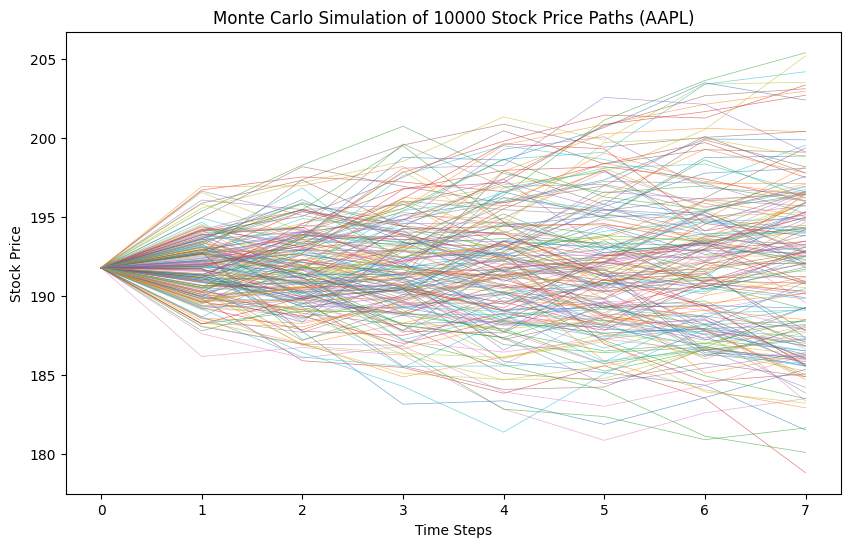

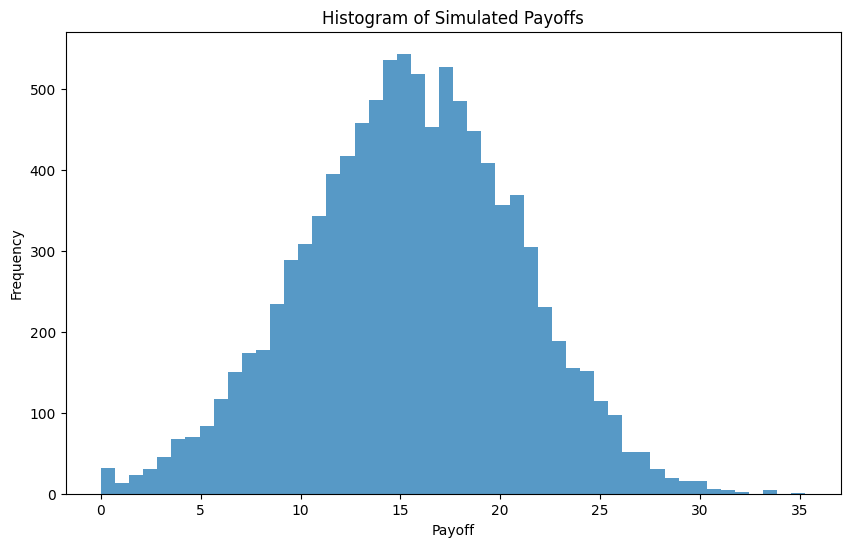

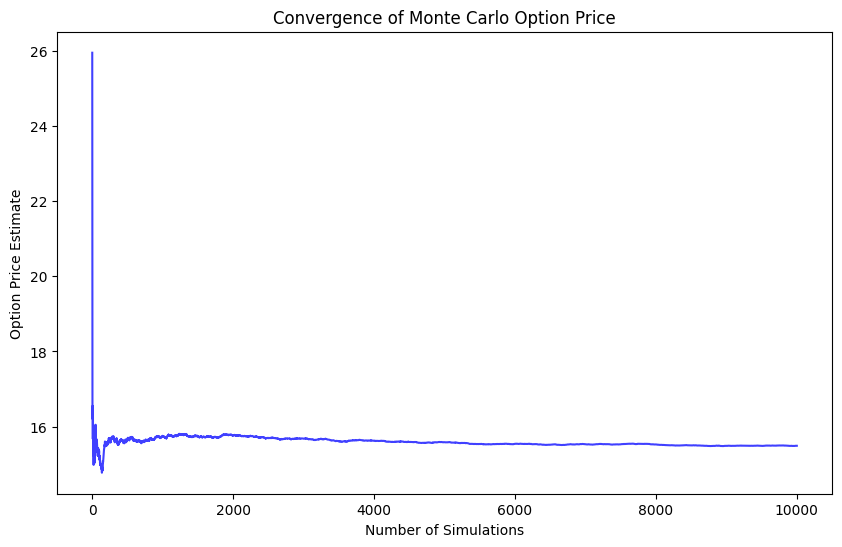

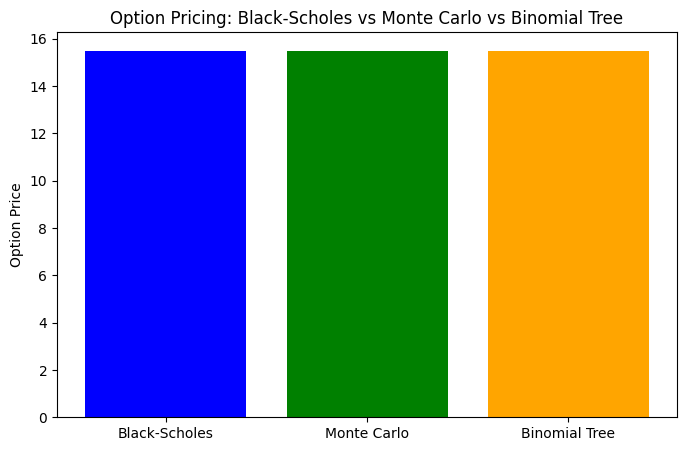

Sigma: 0.0000, Calculated Price: 15.4989, Market Price: 22.2500, Price Diff: -6.7511
Sigma: 10.0000, Calculated Price: 109.9225, Market Price: 22.2500, Price Diff: 87.6725
Sigma: 0.7150, Calculated Price: 17.9346, Market Price: 22.2500, Price Diff: -4.3154
Sigma: 1.9223, Calculated Price: 29.7678, Market Price: 22.2500, Price Diff: 7.5178
Sigma: 1.1553, Calculated Price: 21.9403, Market Price: 22.2500, Price Diff: -0.3097
Sigma: 1.1880, Calculated Price: 22.2604, Market Price: 22.2500, Price Diff: 0.0104
Sigma: 1.1869, Calculated Price: 22.2500, Market Price: 22.2500, Price Diff: -0.0000
Sigma: 1.1869, Calculated Price: 22.2500, Market Price: 22.2500, Price Diff: -0.0000
Sigma: 1.1869, Calculated Price: 22.2500, Market Price: 22.2500, Price Diff: -0.0000
Sigma: 1.1869, Calculated Price: 22.2500, Market Price: 22.2500, Price Diff: 0.0000
Report saved to options_report.txt


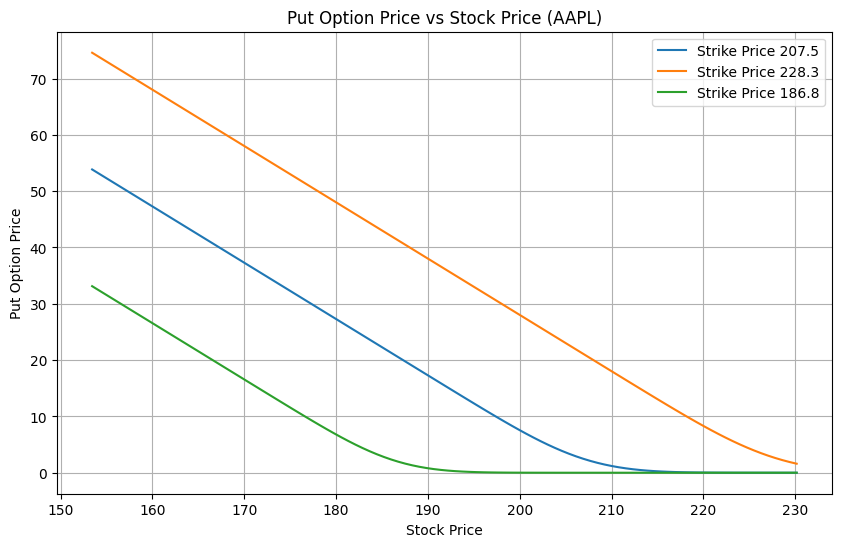

In [1]:
import numpy as np
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import os

option_type = 'put'
OUTPUT_FOLDER = "output"

def black_scholes_option(S, K, T, r, sigma, q=0):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    
    return price

# Binomial Tree Model
def binomial_tree_option_price(S, K, T, r, sigma, N):
    dt = T / N  # time step
    u = np.exp(sigma * np.sqrt(dt))  # up factor
    d = 1 / u  # down factor
    p = (np.exp(r * dt) - d) / (u - d)  # risk-neutral probability

    # Initialize asset prices at maturity
    ST = np.zeros(N + 1)
    for i in range(N + 1):
        ST[i] = S * (u ** (N - i)) * (d ** i)

    # Initialize option values at maturity
    if option_type == 'call':
        option_values = np.maximum(0, ST - K)
    else:
        option_values = np.maximum(0, K - ST)

    # Backward induction
    for j in range(N - 1, -1, -1):
        option_values = np.exp(-r * dt) * (p * option_values[:-1] + (1 - p) * option_values[1:])

    return option_values[0]

# Monte Carlo Simulation
def monte_carlo_option_price(S, K, T, r, sigma, num_simulations=10000):
    
    dt = 1 / 365  # Daily steps
    num_steps = int(T * 365)  # Number of days until maturity
    payoffs = [] # This list will store the payoff from each simulation, which will later be averaged to determine the option price.
    paths = []  # To store all paths
    
    estimated_prices = [] # Store for convergence plot
    for _ in range(num_simulations):
        ST = S
        path = [S]  # Store each path (starting with initial stock price)

        for _ in range(num_steps): # step through the stock price over time increments (dt)
            Z = np.random.normal() # Generate a random standard normal variable

            # Geometric Brownian Motion
                #The stock price evolves according to geometric Brownian motion. This means the price has both a deterministic drift (due to the risk-free rate) and a random component (due to volatility)
                    # This formula consists of two parts:
                        # Drift: (r - 0.5 * sigma^2) * dt which reflects the deterministic growth of the stock price.
                        # Volatility: sigma * sqrt(dt) * Z, which reflects randomness in price fluctuations.
            ST *= np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * Z) # The new stock price ST is updated based on the formula for geometric Brownian motion:
            path.append(ST)  # Store each step of the path
        paths.append(path)  # Append the full path
        if option_type == 'call':
            payoffs.append(max(0, ST - K))
        else:
            payoffs.append(max(0, K - ST))


        # Update estimated option price for convergence plot
        estimated_prices.append(np.exp(-r * T) * np.mean(payoffs))
    # Discount Factor: np.exp(-r * T): The payoffs are discounted to present value using exp(-r * T), which accounts for the time value of money, ensuring that future payoffs are valued at today's price.
    # Average Payoff: np.mean(payoffs) : Calculate the mean of all the simulated payoffs 
    # Return the Option Price: The final option price is the discounted average payoff.


    # Plot all paths
    # Visualization 1: Stock price paths
    plt.figure(figsize=(10, 6))
    for path in paths[:200]:  # Limit to 200 paths for better clarity
        plt.plot(path, linewidth=0.5, alpha=0.6)
    
    plt.title(f'Monte Carlo Simulation of {num_simulations} Stock Price Paths ({ticker})')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plot_path = os.path.join(OUTPUT_FOLDER, 'Monte Carlo_Paths.png')
    plt.savefig(plot_path)
    plt.show()

    # Visualization 2: Histogram of payoffs
    plt.figure(figsize=(10, 6))
    plt.hist(payoffs, bins=50, alpha=0.75)
    plt.title('Histogram of Simulated Payoffs')
    plt.xlabel('Payoff')
    plt.ylabel('Frequency')
    plot_histogram = os.path.join(OUTPUT_FOLDER, 'Payoff_Histogram.png')
    plt.savefig(plot_histogram)
    plt.show()

    # Visualization 3: Convergence plot
    plt.figure(figsize=(10, 6))
    plt.plot(estimated_prices, color='blue', alpha=0.75)
    plt.title('Convergence of Monte Carlo Option Price')
    plt.xlabel('Number of Simulations')
    plt.ylabel('Option Price Estimate')
    plot_convergence = os.path.join(OUTPUT_FOLDER, 'Convergence_Plot.png')
    plt.savefig(plot_convergence)
    plt.show()
    return np.exp(-r * T) * np.mean(payoffs) 

# Function for Comparative Pricing Visualization
def comparative_pricing_plot(bs_price, mc_price, bt_price):
    methods = ['Black-Scholes', 'Monte Carlo', 'Binomial Tree']
    prices = [bs_price, mc_price, bt_price]
    
    plt.figure(figsize=(8, 5))
    plt.bar(methods, prices, color=['blue', 'green', 'orange'])
    plt.title('Option Pricing: Black-Scholes vs Monte Carlo vs Binomial Tree')
    plt.ylabel('Option Price')
    plot_comparison = os.path.join(OUTPUT_FOLDER, 'Pricing_Comparison.png')
    plt.savefig(plot_comparison)
    plt.show()

# General Greeks function
def greeks(S, K, T, r, sigma, q=0):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        delta = norm.cdf(d1)
        theta = (- (S * np.exp(-q * T) * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) -
                  r * K * np.exp(-r * T) * norm.cdf(d2))
        rho = K * T * np.exp(-r * T) * norm.cdf(d2)
    else:
        delta = norm.cdf(d1) - 1
        theta = (- (S * np.exp(-q * T) * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) +
                  r * K * np.exp(-r * T) * norm.cdf(-d2))
        rho = -K * T * np.exp(-r * T) * norm.cdf(-d2)

    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * np.exp(-q * T) * norm.pdf(d1) * np.sqrt(T)

    return delta, gamma, vega, theta, rho

# Function to calculate implied volatility
def implied_volatility(S, K, T, r, market_price):
    def option_price_diff(sigma):
        price = black_scholes_option(S, K, T, r, sigma, q=0)
        price_diff = price - market_price
        print(f"Sigma: {sigma:.4f}, Calculated Price: {price:.4f}, Market Price: {market_price:.4f}, Price Diff: {price_diff:.4f}")
        return price_diff

    return brentq(option_price_diff, 1e-6, 10)  # Solve for sigma

# Fetch stock data from Yahoo Finance
def get_stock_data(ticker):
    try:
        data = yf.download(ticker, start="2023-01-01", end="2024-01-01")
        if data.empty:
            raise ValueError("No data found for the given ticker.")
        return data
    except Exception as e:
        print(f"Error fetching stock data: {e}")
        return None

# Calculate historical volatility (annualized)
def calculate_volatility(data):
    data['Returns'] = data['Adj Close'].pct_change()  # Calculate daily returns
    historical_volatility = data['Returns'].std() * np.sqrt(252)  # Annualized volatility
    return historical_volatility

# Function to plot option price vs stock price
def plot_option_price_vs_stock_price(S_range, K_list, T, r, sigma):
    plt.figure(figsize=(10, 6))
    for K in K_list:
        option_prices = [black_scholes_option(S, K, T, r, sigma, q=0) for S in S_range]
        plt.plot(S_range, option_prices, label=f"Strike Price {K:.1f}")

    plt.title(f"{option_type.capitalize()} Option Price vs Stock Price ({ticker})")
    plt.xlabel("Stock Price")
    plt.ylabel(f"{option_type.capitalize()} Option Price")
    plt.legend()
    plt.grid(True)
    plot_path = os.path.join(OUTPUT_FOLDER, 'Option_price_vs_stock_price.png')
    plt.savefig(plot_path)
    plt.show()

# Function to generate report
def generate_report(ticker, S, K, T, r, sigma, bs_price, delta, gamma_val, vega_val, theta_val, rho_val, iv, market_price, mc_price, bt_price):
    os.makedirs("output", exist_ok=True)

    report = f"""
    Options Pricing and Greeks Calculation Report

    1. User Inputs:
    - Stock Ticker: {ticker}
    - Stock Price (S): {S:.1f}
    - Strike Price (K): {K}
    - Days to Expiration: {int(T * 365)} days
    - Risk-Free Rate (r): {r * 100:.2f}%
    - Market Price of the Option: {market_price}

    2. Calculated Intermediate Values:
    - Time to Maturity (T): {T:.4f} years
    - Historical Volatility (σ): {sigma * 100:.2f}%

    3. Option Prices:
    - Option Price (Black-Scholes): {bs_price:.2f}
    - Option Price (Monte Carlo): {mc_price:.2f}
    - Option Price (Binomial Tree): {bt_price:.2f}

    4. Greeks:
    - Delta: {delta:.4f}
    - Gamma: {gamma_val:.4f}
    - Vega: {vega_val:.4f}
    - Theta: {theta_val:.4f}
    - Rho: {rho_val:.4f}

    5. Implied Volatility Calculation:
    - Implied Volatility (IV): {iv * 100:.2f}%
    """
    
    report_path = os.path.join(OUTPUT_FOLDER, "options_report_old.txt")
    with open(report_path, "w") as file:
        file.write(report)

    print("Report saved to options_report.txt")


# Main code
if __name__ == "__main__":
    ticker = 'AAPL'
    K = 207.5
    days_to_maturity = 7
    T = days_to_maturity / 365
    r = 0.05  # Risk-free rate (5%)
    stock = yf.Ticker(ticker)
    unadjS = stock.history(period="1d")['Close'][-1]  # Get the most recent close price (unadjusted)

    # Fetch stock data
    data = get_stock_data(ticker)
    if data is not None:
        S = data['Adj Close'][-1]  # Latest stock price (adjusted for dividends and splits)

        print(f'Adjusted current stock price = {S:.2f} while the unadjusted value = {unadjS:.2f}.')
        sigma = calculate_volatility(data)  # Historical volatility

        # Calculate option prices
        bs_price = black_scholes_option(S, K, T, r, sigma, q=0)
        mc_price = monte_carlo_option_price(S, K, T, r, sigma)
        bt_price = binomial_tree_option_price(S, K, T, r, sigma, N=100)

        # Generate comparative pricing plot
        comparative_pricing_plot(bs_price, mc_price, bt_price)
        # Calculate Greeks for call option
        delta, gamma_val, vega_val, theta_val, rho_val = greeks(S, K, T, r, sigma)

        # Implied volatility calculation
        market_price = 22.25
        iv = implied_volatility(S, K, T, r, market_price)

        # Generate and save report
        generate_report(ticker, S, K, T, r, sigma, bs_price, delta, gamma_val, vega_val, theta_val, rho_val, iv, market_price, mc_price, bt_price)

        # Plot call and put option price vs stock price
        S_range = np.linspace(S * 0.8, S * 1.2, 100)  # Stock price range for plot
        K_list = [K, K * 1.1, K * 0.9]  # Different strike prices for comparison

        plot_option_price_vs_stock_price(S_range, K_list, T, r, sigma)
